#### ASTR 3890 - Selected Topics: Data Science for Large Astronomical Surveys (Spring 2022)
***N. Hernitschek***
___

# Homework 7
### Due: Monday, Mar 21th at 11.00am CST

The completed lecture notebook must also be submitted by 11:00am Central Time on March 21th.

---

## Problem 1

**Fitting Data with MCMC**

Start with the code snipplet below to generate data.
Then, following the approach shown in `lecture_7.ipynb`, using either `emcee` or `pymc3`, fit a straight line to the data. Create the trace plots.

- Describe/ discuss where you should cut off burn-in. 
- Compute the autocorrelation length of the chain. 
- Using `corner`, make a corner plot that has labels, shows titles, and has $68\%$ and $95\%$ quantiles and levels. 








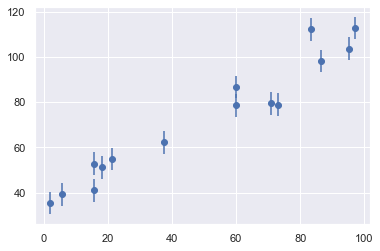

In [226]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import seaborn; seaborn.set() # for plot formatting
import pymc3 as pm

def make_data(intercept, slope, N=15, dy=5, rseed=42):
    rand = np.random.RandomState(rseed)
    x = 100 * rand.rand(N)
    y = intercept + slope * x
    y += dy * rand.randn(N)
    return x, y, dy * np.ones_like(x)

theta_true = (37, 0.75)
x, y, dy = make_data(*theta_true)

plt.errorbar(x, y, dy, fmt='o');

### Solution

In [214]:
# Fit a straight line to the data using pymc3
# Adapted from lecture 7
with pm.Model():
    
    # Define priors for each parameter
    m = pm.Uniform('m', -5, 5) 
    b = pm.Uniform('b', -50, 50)
    log = pm.Uniform('log', -10, 10) 

    # set up our observed variable x
    # i.e. read this as 'x is distributed as a Normal variable'
    pm.Normal("obs", mu=m * x + b, sd=pm.math.exp(log), observed=y)

    trace = pm.sample(draws=5000, tune=3000, cores=1, return_inferencedata=False)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [log, b, m]


Sampling 2 chains for 3_000 tune and 5_000 draw iterations (6_000 + 10_000 draws total) took 7 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.


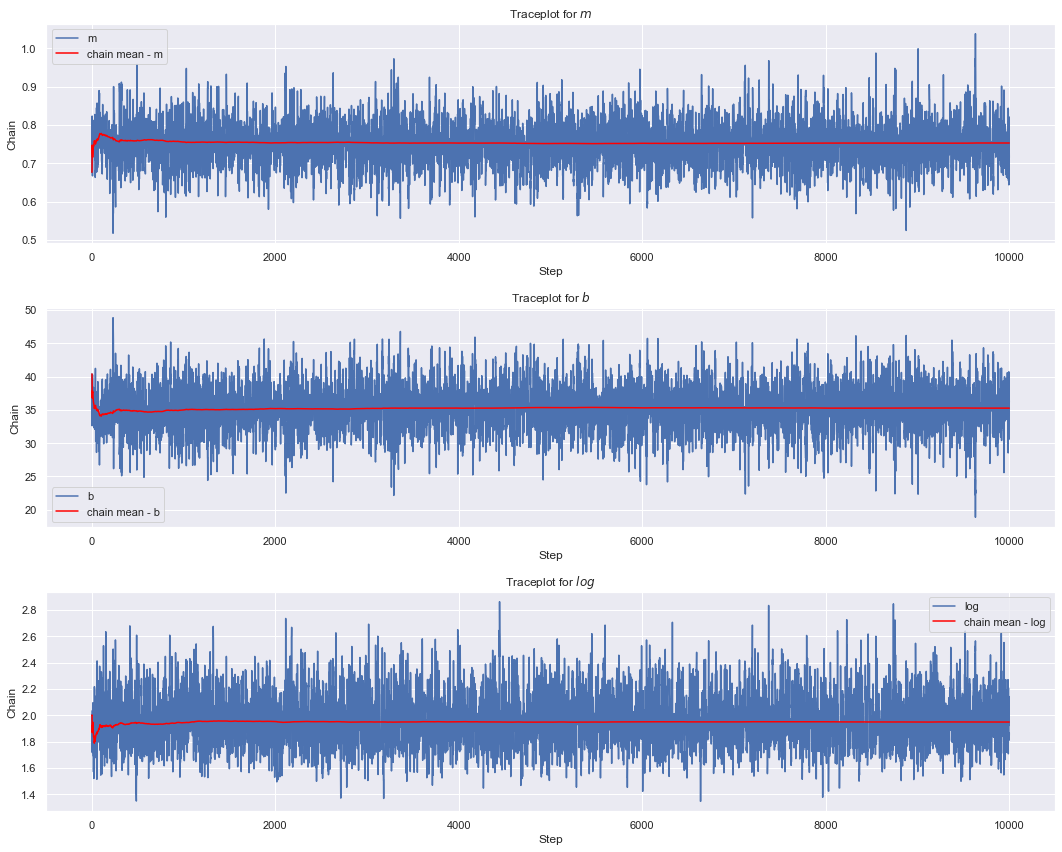

In [215]:
# Make traceplots (starting with m)
fig = plt.figure(figsize=(15, 12))
ax = fig.subplots(3, 1)

m_chain = trace['m']
b_chain = trace['b']
log_chain = trace['log']
M = np.size(m_chain)

# Plot m trace
xgrid = np.linspace(1, M, M)
ax[0].plot(xgrid, m_chain, label='m')
#ax[0].set_ylim(np.min(m_chain), 1.1*np.max(m_chain))
ax[0].set_xlabel('Step')
ax[0].set_ylabel('Chain')
ax[0].set_title('Traceplot for $m$')

# Plot b trace
ax[1].plot(xgrid, b_chain, label='b')
ax[1].set_xlabel('Step')
ax[1].set_ylabel('Chain')
ax[1].set_title('Traceplot for $b$')

# Plot log trace
ax[2].plot(xgrid, log_chain, label='log')
ax[2].set_xlabel('Step')
ax[2].set_ylabel('Chain')
ax[2].set_title('Traceplot for $log$')

# Plot running mean for each: 
mean_m = [np.mean(m_chain[:int(N)]) for N in xgrid]
ax[0].plot(xgrid, mean_m, c='red', label='chain mean - m') 

mean_b = [np.mean(b_chain[:int(N)]) for N in xgrid]
ax[1].plot(xgrid, mean_b, c='red', label='chain mean - b') 

mean_log = [np.mean(log_chain[:int(N)]) for N in xgrid]
ax[2].plot(xgrid, mean_log, c='red', label='chain mean - log') 

ax[0].legend()
ax[1].legend()
ax[2].legend()
plt.tight_layout()
plt.show()

Got error No model on context stack. trying to find log_likelihood in translation.
/Users/sambianco/opt/anaconda3/envs/astr3890/lib/python3.8/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
Got error No model on context stack. trying to find log_likelihood in translation.


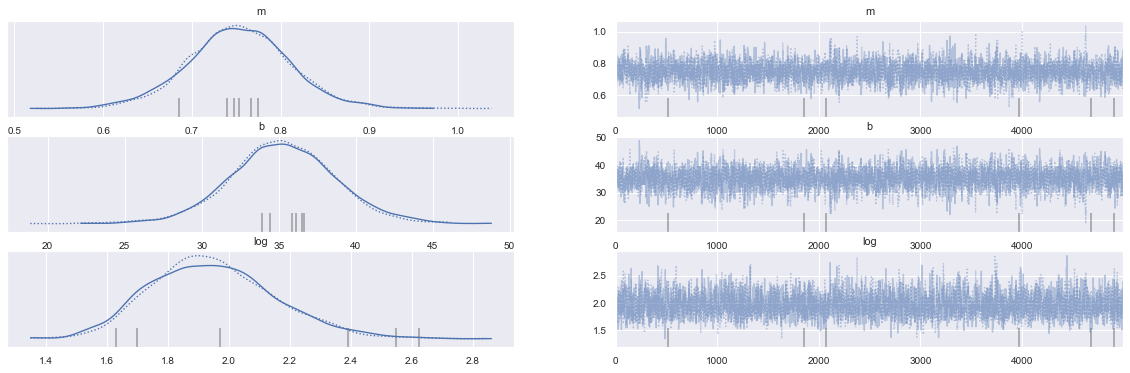

In [216]:
# Another method for traceplot
pm.plot_trace(trace,figsize=(20,6));

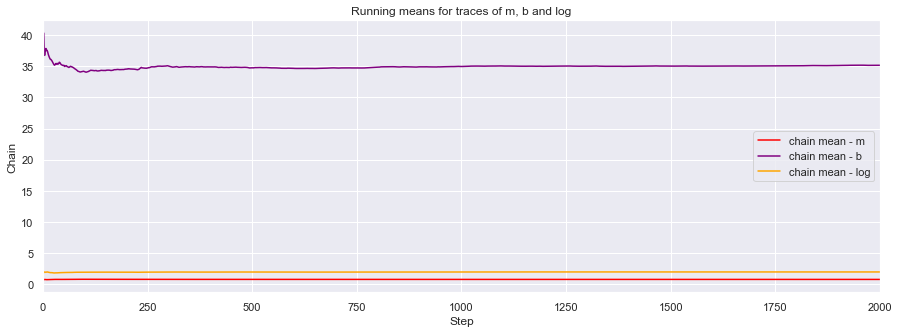

In [217]:
# Plot all three running means together (with zoom into first steps) to determine where to cut off burn in
fig = plt.figure(figsize=(15, 5))

# Plot running means: 
plt.plot(xgrid, mean_m, c='red', label='chain mean - m') 
plt.plot(xgrid, mean_b, c='purple', label='chain mean - b') 
plt.plot(xgrid, mean_log, c='orange', label='chain mean - log') 

plt.title('Running means for traces of m, b and log')
plt.xlabel('Step')
plt.ylabel('Chain')
plt.xlim(0, 2000)
plt.legend()
plt.show()

In MCMC, the process must be stationary, and the chain statistics should look the same in each part of the chain. This is not the case in early steps of the chain, so the solution is to discard the first few steps, or the burn-in phase.

Burn-in should be cut off when the running means of m, b, and log start to stabilize. m and log stabilize fairly quickly, but it takes a while for b to get there. At around 400 steps into the process, the running mean for b looks pretty good. However, I wouldn't say that it is completely stable until around the 900th step.

In [218]:
# Compute autocorrelation length of the chain
autocorr_m = pm.autocorr(m_chain)
autocorr_b = pm.autocorr(b_chain)
autocorr_log = pm.autocorr(log_chain)

print(autocorr_m, '\n', autocorr_b, '\n', autocorr_log)

[ 1.00000000e+00  4.96813028e-01  2.76889469e-01 ... -4.63640504e-05
  8.15186874e-05  8.85499032e-05] 
 [1.00000000e+00 4.98017094e-01 2.75147135e-01 ... 1.20762753e-04
 1.11229130e-04 4.05362345e-05] 
 [ 1.00000000e+00  4.68448999e-01  2.48199835e-01 ...  3.85511858e-06
 -2.78967986e-05 -1.03823192e-05]


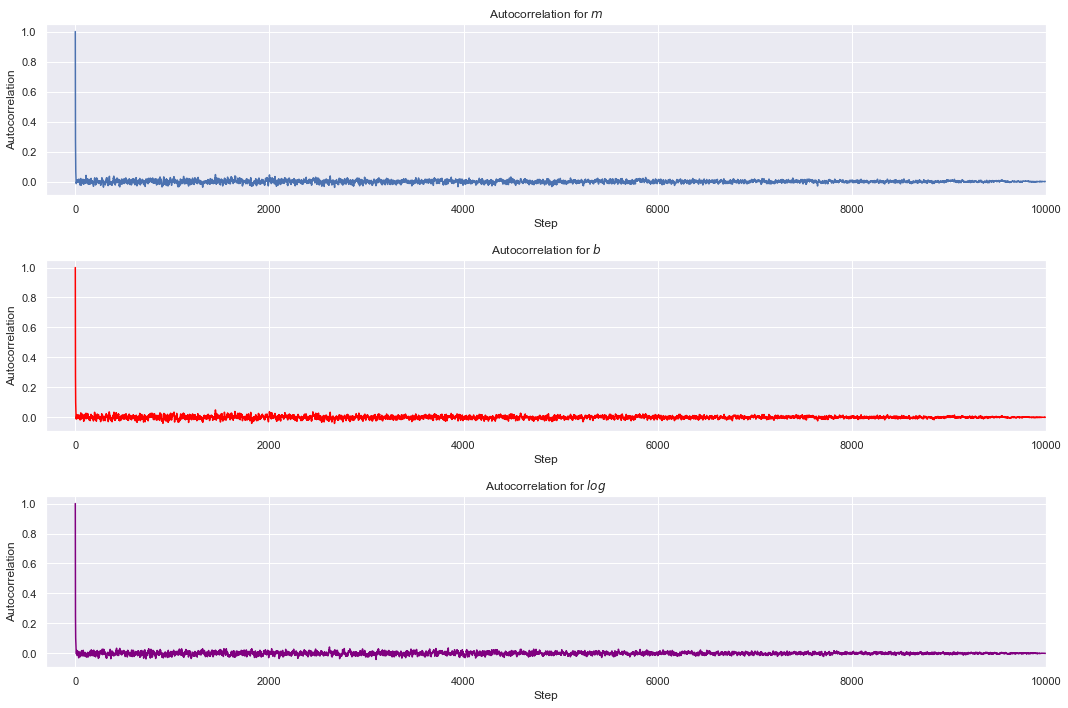

In [219]:
# Plot autocorrelation length as a function of steps
fig = plt.figure(figsize=(15, 10))
ax = fig.subplots(3, 1)

# Plot m autocorrelation
ax[0].plot(xgrid, autocorr_m, label='m')
ax[0].set_xlabel('Step')
ax[0].set_ylabel('Autocorrelation')
ax[0].set_xlim(-300, 10000)
ax[0].set_title('Autocorrelation for $m$')

# Plot m autocorrelation
ax[1].plot(xgrid, autocorr_b, c="red", label='m')
ax[1].set_xlabel('Step')
ax[1].set_ylabel('Autocorrelation')
ax[1].set_xlim(-300, 10000)
ax[1].set_title('Autocorrelation for $b$')

# Plot log autocorrelation
ax[2].plot(xgrid, autocorr_log, c="purple", label='log gamma')
ax[2].set_xlabel('Step')
ax[2].set_ylabel('Autocorrelation')
ax[2].set_xlim(-300, 10000)
ax[2].set_title('Autocorrelation for $log$')

plt.tight_layout()
plt.show()

Got error No model on context stack. trying to find log_likelihood in translation.
/Users/sambianco/opt/anaconda3/envs/astr3890/lib/python3.8/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


Quantiles:
[(0.68, 0.7786453304473981), (0.95, 0.8462750009154432)]
Quantiles:
[(0.68, 36.78969069578143), (0.95, 40.83333561243688)]
Quantiles:
[(0.68, 2.0331317056191205), (0.95, 2.305631836398953)]


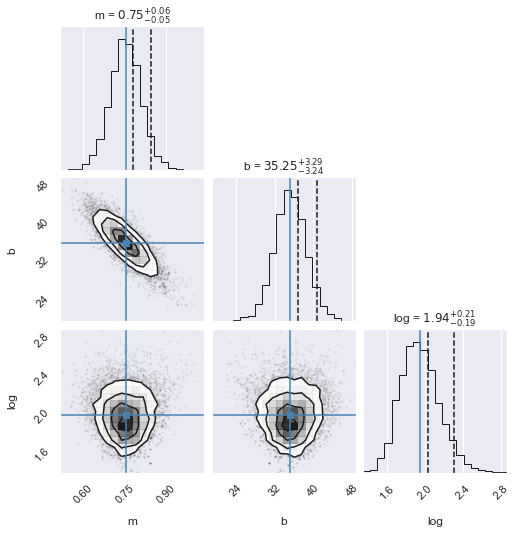

In [220]:
# Make corner plot
m = np.mean(m_chain)
b = np.mean(b_chain)
log = np.mean(log_chain)

corner.corner(trace, labels=['m', 'b', 'log'], 
              quantiles=[0.68, 0.95], verbose=True, show_titles=True,
              truths=dict(m=m, b=b, log=log));

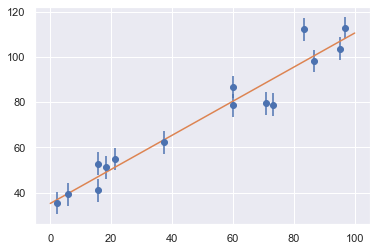

In [221]:
# Fit line with parameters to data

x, y, dy = make_data(*theta_true)

plt.errorbar(x, y, dy, fmt='o')

grid = np.linspace(0, 100, 100)
plt.plot(grid, m * grid + b)
plt.show()

This is a good fit!